#CafChem tools for building a GPT model, or fine-tuning a GPT model to produce molecules based on a user-provided dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/GPT_CafChem.ipynb)

## This notebook allows you to:
- Read in a CSV file with SMILES strings and tokenize it.
- Train or finetune a GPT on this dataset.
- Save the GPT for future use.
- upload a saved GPT.
- test GPT by generating sample molecules

## Requirements:
- This notebook will install deepchem
- It will pull the CafChem tools from Github.
- It will install all needed libraries.


## Set-up

This block:

- Loads all needed modules/libraries
    
- pulls CafChem from github

In [1]:
!pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 27.0 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 398 (delta 102), reused 45 (delta 42), pack-reused 259 (from 2)
Receiving objects: 100% (398/398), 29.02 MiB | 12.76 MiB/s, done.
Resolving deltas: 100% (213/213), done.


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import transformers
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
import CafChem.CafChemGPT as ccgpt

print("All libraries loaded!")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


All libraries loaded!


## Tokenize

In [14]:
fx, fy, VOCAB_SIZE, tokenizer, max_length = ccgpt.make_datasets("/content/905-unique-statins.csv", "Ligand SMILES")

118 20
Vocabulary size for this dataset:  100
Number of features and datapoints, targets:  (905, 117) (905, 117)
featurization done with:  SMILES Tokenizer


In [15]:
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Max length: {max_length}")

Vocabulary size: 100
Max length: 118


## Training the model

- This block defines the sequential model and runs the optimization.

- can load previous weights

In [16]:
gpt = ccgpt.make_gpt(2, max_length, VOCAB_SIZE)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, None, 256)      │        55,808 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,450,532 (9.35 MB)

 Trainable params: 2,450,532 (9.35 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
batch_size = 512
gpt.compile("adam",loss=[tf.keras.losses.SparseCategoricalCrossentropy(),None])
gpt.fit(fx,fy,epochs = 2, batch_size = batch_size)

Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 22s/step - loss: 4.1133
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 1.1051


## saving

In [18]:
gpt.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, None, 256)      │        55,808 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,351,598 (28.04 MB)

 Trainable params: 2,450,532 (9.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,901,066 (18.70 MB)

In [19]:
ccgpt.save_gpt(gpt, "GPT_statin_2epochs")

New layer names:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1_original          │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1… │ (None, None, 256)      │        55,808 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2_original    │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3_original    │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9_original (Dense)        │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,351,598 (28.04 MB)

 Trainable params: 2,450,532 (9.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,901,066 (18.70 MB)

model saved with name: GPT_statin_2epochs.
layer names saved in file: layer_store_GPT_statin_2epochs.


## Set up Xfer learning
- first, upload a training set and test the vocabulary to see if your dataset is compatible with the Foundation model usedfor fine-tuning. It will check if you dataset has any token not included in the foundation model, and check to see if the context window for your dataset is within the context window for the foundation model.
- if it is compatible, tokenize your dataset.
- then create a new model that has 2 transformer blocks/layers pre-loaded from the foundation model, with a user-specified number of new blocks for fine-tuning. By default the old blocks are frozen for training, but you can toggle this.
- (optionally unfreeze the old blocks/layers)
- finally train the model. About 50 epochs of training minumum are usually required for fine-tuning

In [12]:
novel_tokens = ccgpt.test_vocab("/content/maob_4015_ic50.csv", "SMILES")

463 10
New vocabulary size:  45
Vocabulary size for standard dataset:  100
. not in standard vocabulary
[18F] not in standard vocabulary
[2H] not in standard vocabulary
[11c] not in standard vocabulary
[Te] not in standard vocabulary
[Se] not in standard vocabulary
This dataset is not compatible with the Foundation model vocabulary
This dataset's context window is not compatible with the Foundation model.


In [32]:
fx, fy, VOCAB_SIZE, tokenizer, max_length = ccgpt.make_datasets("/content/905-unique-statins.csv", "Ligand SMILES")

118 20
Vocabulary size for this dataset:  100
Number of features and datapoints, targets:  (905, 117) (905, 117)
featurization done with:  SMILES Tokenizer


In [33]:
gpt_2x_2 = ccgpt.make_finetune_gpt(2, freeze_old_layers=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_3  │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_8             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_9             │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_10            │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_11            │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,831,844 (18.43 MB)

 Trainable params: 4,831,844 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

Reading in layers:
input_layer_original
token_and_position_embedding_original
transformer_block_original
transformer_block_1_original
dense_4_original
input_layer_original has been named!
token_and_position_embedding_original has been named!
transformer_block_original has been named!
transformer_block_1_original has been named!
transformer_block_X_1 has been named!
transformer_block_X_2 has been named!
setting layer input_layer_original untrainable.
setting layer token_and_position_embedding_original untrainable.
setting layer transformer_block_original untrainable.
setting layer transformer_block_1_original untrainable.
setting layer transformer_block_X_1 trainable.
setting layer transformer_block_X_2 trainable.
setting layer dense_X trainable.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:629: UserWarning: A total of 16 objects could not be loaded. Example error message for object <EinsumDense name=key, built=True>:

Layer 'key' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <Dense name=dense_23, built=True>, <Dense name=dense_24, built=True>, <LayerNormalization name=layer_normalization_20, built=True>, <LayerNormalization name=layer_normalization_21, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <Dense name=dense_25, built=True>, <Dense name=dense_26, built=True>, <LayerNormalization name=layer_normalization_22, built=True>, <L

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_original            │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_o… │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_original      │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1_original    │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_1           │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_2           │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_X (Dense)                 │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,831,844 (18.43 MB)

 Trainable params: 2,394,724 (9.14 MB)

 Non-trainable params: 2,437,120 (9.30 MB)

In [38]:
gpt_2x_2 = ccgpt.unfreeze_gpt(gpt_2x_2)

setting layer input_layer_original trainable.
setting layer token_and_position_embedding_original trainable.
setting layer transformer_block_original trainable.
setting layer transformer_block_1_original trainable.
setting layer transformer_block_X_1 trainable.
setting layer transformer_block_X_2 trainable.
setting layer dense_X trainable.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_original            │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_o… │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_original      │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1_original    │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_1           │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_X_2           │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_X (Dense)                 │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,621,294 (36.70 MB)

 Trainable params: 4,831,844 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,789,450 (18.27 MB)

In [39]:
batch_size = 512
gpt_2x_2.compile("adam",loss=[tf.keras.losses.SparseCategoricalCrossentropy(),None])

gpt_2x_2.fit(fx,fy,epochs = 50, batch_size = batch_size)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 14s/step - loss: 0.7213
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - loss: 1.1610
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - loss: 0.7700
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - loss: 0.4854
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - loss: 0.4518
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - loss: 0.3952
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - loss: 0.3619
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - loss: 0.3330
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - loss: 0.3064
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - loss: 0.2883
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - loss: 0.2656
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - loss: 0.2521
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - loss: 0.2404
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - loss: 0.2249
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - loss: 0.2163
Epoch 16/50
2/2 ━━━━

In [ ]:
ccgpt.save_gpt(gpt_2x_2, "GPT_statin_2epochs")

model saved.


## Standard molecule prediction

This block

- Takes two strings (statin drugs and the natural substrate for HMGCoAReductase) to use as "seeds"

- Tokenizes the strings
- Makes the input for the predictor by making 2 inputs with **string_length** characters (string_length
is the length of the shortest string in the input. Can be set to any number)
- predictes a new character with the model (the most probable character) and then adds that to the input string,
so that the input is one character longer.
- uses the new input to predict the next chacacter, etc.

In [49]:
gpt_found = ccgpt.load_foundation()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_7  │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_18            │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_19            │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,462,820 (9.39 MB)

 Trainable params: 2,462,820 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

input_layer_original
token_and_position_embedding_original
transformer_block_original
transformer_block_1_original
dense_4_original
input_layer_original has been named!
token_and_position_embedding_original has been named!
transformer_block_original has been named!
transformer_block_1_original has been named!
dense_4_original has been named!
Foundation model loaded.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_original            │ (None, None)           │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_o… │ (None, None, 256)      │        68,096 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_original      │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1_original    │ [(None, None, 256),    │     1,184,512 │
│ (TransformerBlock)              │ (None, 4, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4_original (Dense)        │ (None, None, 100)      │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,462,820 (9.39 MB)

 Trainable params: 2,462,820 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
pic = ccgpt.test_gen(gpt_found,tokenizer,1.0,VOCAB_SIZE, 42)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
using variable temp generation with 1.0.
(5, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
using variable temp generation with 1.0.
(5, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
using variable temp generation with 1.0.
(5, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
using variable temp generation with 1.0.
(5, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
using variable temp generation with 1.0.
(5, 8)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
using variable temp generation with 1.0.
(5, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
using variable temp generation with 1.0.
(5, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
using variable temp generation with 1.0.
(5, 11)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
using variable temp generation with 1.0.
(5, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
using variable temp generation with 1.0.
(5, 13)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
using variable temp generation with 1.0.
(5, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
using variable temp generatio

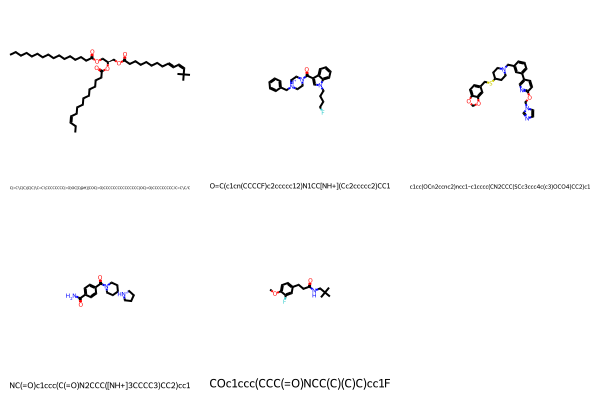

In [51]:
pic

## Create specific vocab list

- First block must be run before using this block. Then swap out the old vocab file for the new one and rerun
first block.
- reads in original vocab list
- uses the fl2set from the first block: this is a set with all unique tokens used in this model
- if a token is used, it is added to the new vocab list
- Note: [unused] must be added after [PAD] if it is not included

In [ ]:
#routine to create a smaller vocab_file based on the dataset using fl2set
oldvocab = open("vocab.txt","r")
oldvocab_lines = oldvocab.readlines()
oldvocab.close()

newvocab = open("vocab_350K.txt","w",newline="\n")

for i in range(len(oldvocab_lines)):
    if i in fl2set:
        print(oldvocab_lines[i])
        newvocab.write(oldvocab_lines[i])

newvocab.close()

[PAD]

[CLS]

[SEP]

c

C

(

)

O

1

2

=

N

n

3

F

Cl

-

4

[C@H]

S

[C@@H]

[O-]

Br

#

/

[nH]

[N+]

s

5

o

P

[Si]

I

B

[C@]

[C@@]

6

\

[N-]

[c-]

[O+]

7

[n+]

[Sn]

[CH]

[C-]

[B-]

[P+]

[C]

8

[nH+]

[NH3+]

[S@]

[S@@]

[S-]

[PH]

[NH2+]

[S+]

[NH+]

9

[cH-]

[O]

[SH]

[PH+]

[C+]

[SnH]

%10

[CH2-]

[n-]

[NH-]

[PH2]

%11

[N]

[P@]

[s+]

[CH-]

[CH+]

%12

[P@@]

[o+]

%13

[S@+]

[S@@+]

[SH+]

[OH+]

%14

%15

%16

[N@@+]

[N@+]

[125I]

%17

%18

%19

%20

%21

[P@@H]

[131I]

[P@H]

